# Notebook Dedicado a Tratar eventos únicos y Observar clustering de Datos

In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

from sklearn.cluster import KMeans

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [3]:
file = uproot.open("/snoplus simulations/electron bulk/center point/z direction/Low Statistic/simu_Analysis_elec_z_10MeV.root")
file.keys()

['T;6', 'T;5', 'pmt;2', 'pmt;1']

In [4]:
data1 = file['T;6']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [5]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

## 1.1 - EV info

In [6]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
#mc_position = np.array(data1['mc_position'])   -> Position Generation
#mc_momentum = np.array(data1['mc_momentum'])   -> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

## 1.2 - PMT info

In [7]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Select Data

## 2.1 - Extract  valid PMT id

In [8]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([       0,        1,        2, ..., 12913869, 12913870, 12913871],
      dtype=int64)

### 2.1.1 - Extraer información valida de PMT info

In [9]:
valid_pmt_xyz = []

for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

## 2.2 - Extracción y cortes en Datos de Eventos Validos

In [10]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 5
#time cut
inf_cut = -5
up_cut = 10

#radial cut
radi_cut_method = False   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0
#--------------------------------------------------------------------------


# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
#multi_position_cut = []
#multi_mc_momentum_cut = []
multi_mc_ID_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    #multi_position = []
    #multi_mc_position = []
    #multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_mc_ID.append(mcID[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        #multi_position.append(position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        #multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    #multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        event_direction = np.array([0,0,-1])
        #event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        #multi_mc_momentum_cut.append(multi_mc_momentum[i])
        multi_mc_ID_cut.append(multi_mc_ID[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    
#multi_position_cut = np.array(multi_position_cut)
#multi_mc_momentum_cut = np.array(multi_mc_momentum_cut)
multi_mc_ID_cut = np.array(multi_mc_ID_cut, dtype = np.int16)

slipt nº: 0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
computing cos(alpha)
doing time residual cuts


# 2.3 - Separate Event Information 

### 2.3.1 - Encontrar donde $mc_{ID}$ quiebra

In [11]:
break_i = [0] #List of indices where data change of event ID

N_evts = len(multi_mc_ID_cut)
for i in range(N_evts-1):
    if multi_mc_ID_cut[i] != multi_mc_ID_cut[i+1]:
        break_i.append(i+1)    
break_i = np.array(break_i, dtype = np.int32)

-------------------------------------------------------
- Pruebas de observación 

In [58]:
#Pruebas de observacion

i = break_i[0]
f = break_i[1]

#multi_mc_ID_cut[i:f]

#select event data
time_residual_ev = np.array(multi_time_residual_cut[i:f])
cos_angel_ev = np.array(multi_cos_angle_cut[i:f])

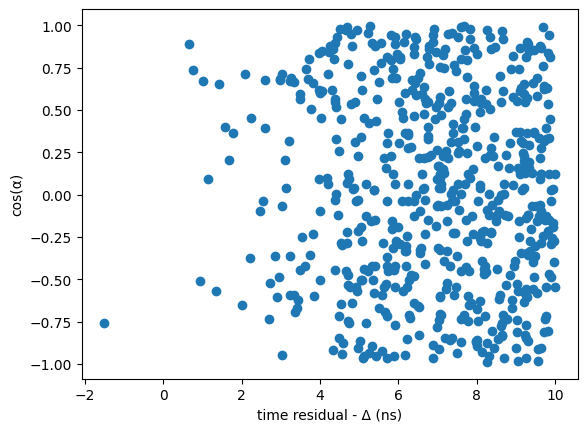

In [59]:
xtitle = 'time residual - Δ (ns)'
ytitle = 'cos(α)'

plt.scatter(time_residual_ev, cos_angel_ev)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
#plt.xscale('log')
plt.show()

In [60]:
data = list(zip(time_residual_ev, cos_angel_ev))

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

KMeans(n_clusters=2)

In [61]:
kmeans.cluster_centers_

array([[8.36916142, 0.01448994],
       [4.83734458, 0.04870038]])

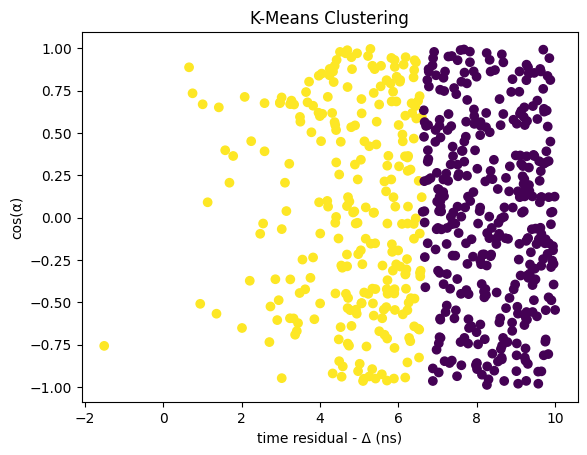

In [63]:
plt.scatter(time_residual_ev, cos_angel_ev, c=kmeans.labels_)
plt.title('K-Means Clustering')
plt.xlabel(xtitle)
plt.ylabel(ytitle)
#plt.xscale('log')
plt.show()

- ### Intentar cortar en residuales en forma de escalera y rehacer clustering

 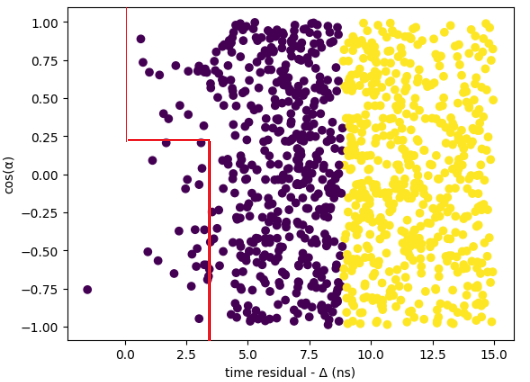

In [64]:
#data cut selection: select data that verify the bellow limits
cut_cos = 0.25
cut_t1 = -2.5
cut_t2 = 3.5

#1º cut
cut_i1 = np.where(time_residual_ev < cut_t1)[0]
time_residual_cut_1 = np.delete(time_residual_ev, cut_i1)
cos_angel_cut_1 = np.delete(cos_angel_ev, cut_i1)

#2º cut
cut_i2 = np.where((cos_angel_cut_1 < cut_cos) & (time_residual_cut_1 < cut_t2))[0]
time_residual_cut_2 = np.delete(time_residual_cut_1, cut_i2)
cos_angel_cut_2 = np.delete(cos_angel_cut_1, cut_i2)

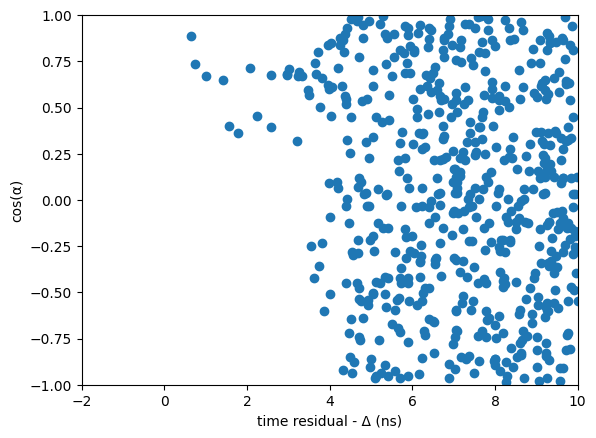

In [65]:
plt.scatter(time_residual_cut_2, cos_angel_cut_2)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
#plt.xscale('log')
plt.xlim(-2,10)
plt.ylim(-1,1)
plt.show()

In [69]:
#Now verify the clustering

data_cut = list(zip(time_residual_cut_2, cos_angel_cut_2))
kmeans = KMeans(n_clusters=10)
kmeans.fit(data_cut)

KMeans(n_clusters=10)

In [70]:
#see centroids
kmeans.cluster_centers_

array([[ 8.18525423, -0.42792679],
       [ 5.1888217 , -0.50017428],
       [ 4.24247869,  0.45544827],
       [ 6.76978673, -0.37670019],
       [ 6.01828241,  0.55956382],
       [ 9.69235352, -0.03688788],
       [ 1.96991723,  0.61582861],
       [ 7.42441751,  0.50288428],
       [ 9.25118489, -0.59651147],
       [ 9.15377263,  0.55331664]])

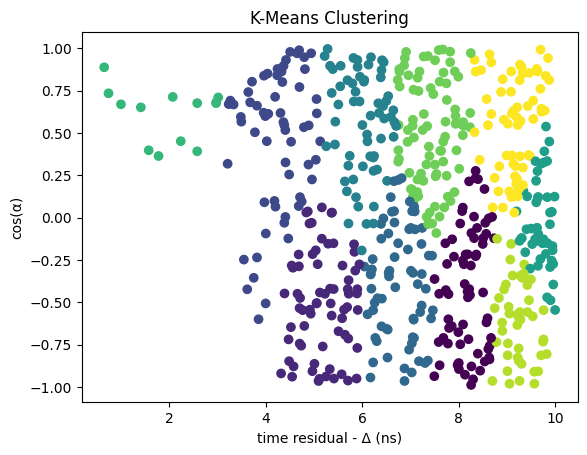

In [71]:
plt.scatter(time_residual_cut_2, cos_angel_cut_2, c=kmeans.labels_)
plt.title('K-Means Clustering')
plt.xlabel(xtitle)
plt.ylabel(ytitle)
#plt.xscale('log')
plt.show()